In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf

In [45]:
df1 = pd.read_csv("./updown.csv")
df2 = pd.read_csv("./leftright.csv")

In [46]:
len(df2)

500

In [ ]:
df1[0:300].head()

In [ ]:
#df1 = df.loc[200:290]
#df2 = df.loc[540:690]
#df2 = df.iloc[int(len(df)/2+1):, :]

500


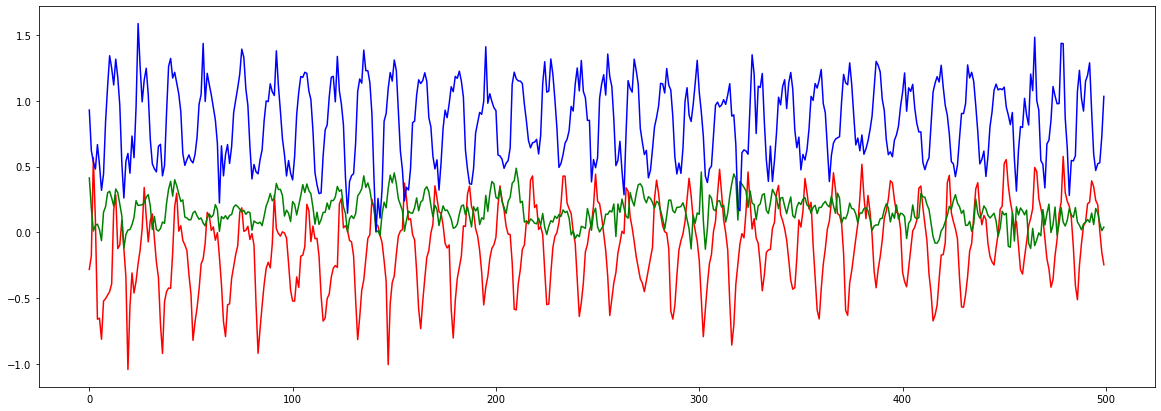

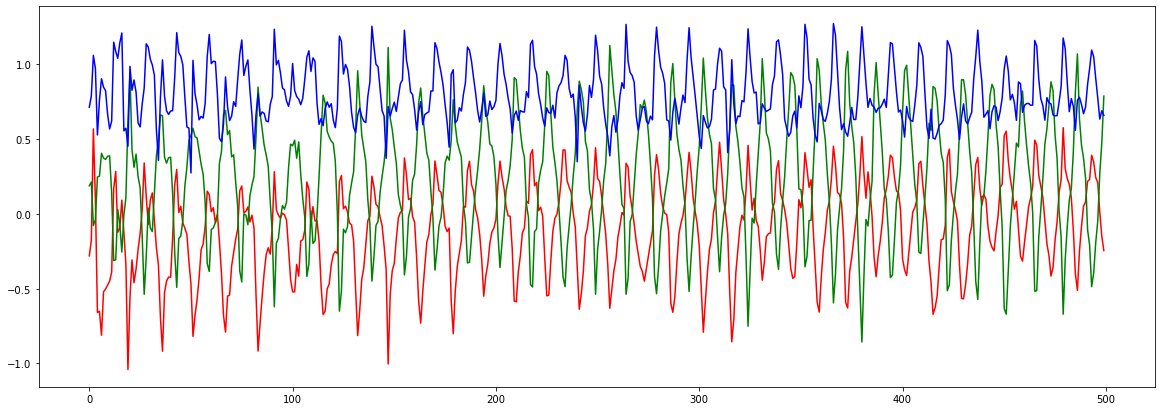

In [47]:
#df[10:300][["gyro_x"]].plot(figsize=(20,14))
fig = plt.figure(figsize=(20, 7))
ax = plt.axes()

print(len(df1))

plt.plot(df2["acc_x"], "r")
plt.plot(df1["acc_y"], "g")
plt.plot(df1["acc_z"], "b")
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(df2["acc_x"], "r")
plt.plot(df2["acc_y"], "g")
plt.plot(df2["acc_z"], "b")
plt.show()

In [48]:
# Here, we prepare the data

In [55]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures 
GESTURES = [
    "updown",
    "leftright"
]

SAMPLES_PER_GESTURE = 10

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print(ONE_HOT_ENCODED_GESTURES)

inputs = []
outputs = []
dfs = [df1, df2]

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = dfs[gesture_index]

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['acc_x'][index] + 4) / 8,
          (df['acc_y'][index] + 4) / 8,
          (df['acc_z'][index] + 4) / 8,
          (df['gyro_x'][index] + 2000) / 4000,
          (df['gyro_y'][index] + 2000) / 4000,
          (df['gyro_z'][index] + 2000) / 4000,
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)


print("Data set parsing and preparation complete.")

TensorFlow version = 2.4.0

[[1. 0.]
 [0. 1.]]
Processing index 0 for gesture 'updown'.
	There are 50 recordings of the updown gesture.
Processing index 1 for gesture 'leftright'.
	There are 50 recordings of the leftright gesture.
Data set parsing and preparation complete.


In [56]:
# Let's split the dataset

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [57]:
# Build and train

# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
# the final layer is softmax because we only expect one gesture to occur per input
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/600
60/60 [==============================] - 1s 9ms/step - loss: 0.2605 - mae: 0.5093 - accuracy: 0.4296 - val_loss: 0.2610 - val_mae: 0.5090 - val_accuracy: 0.4000
Epoch 2/600
60/60 [==============================] - 0s 8ms/step - loss: 0.2406 - mae: 0.4863 - accuracy: 0.6377 - val_loss: 0.2600 - val_mae: 0.5085 - val_accuracy: 0.4000
Epoch 3/600
60/60 [==============================] - 0s 3ms/step - loss: 0.2544 - mae: 0.5026 - accuracy: 0.5195 - val_loss: 0.2635 - val_mae: 0.5102 - val_accuracy: 0.4000
Epoch 4/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2508 - mae: 0.4978 - accuracy: 0.5197 - val_loss: 0.2522 - val_mae: 0.5021 - val_accuracy: 0.5000
Epoch 5/600
60/60 [==============================] - 0s 3ms/step - loss: 0.2520 - mae: 0.5013 - accuracy: 0.4521 - val_loss: 0.2672 - val_mae: 0.5130 - val_accuracy: 0.4000
Epoch 6/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2475 - mae: 0.4931 - accuracy: 0.5645 - val_loss: 0.2592 - v

60/60 [==============================] - 0s 2ms/step - loss: 0.2460 - mae: 0.4918 - accuracy: 0.5504 - val_loss: 0.2657 - val_mae: 0.5115 - val_accuracy: 0.4000
Epoch 49/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2452 - mae: 0.4912 - accuracy: 0.5436 - val_loss: 0.2682 - val_mae: 0.5130 - val_accuracy: 0.4000
Epoch 50/600
60/60 [==============================] - 0s 3ms/step - loss: 0.2498 - mae: 0.4954 - accuracy: 0.5453 - val_loss: 0.2631 - val_mae: 0.5098 - val_accuracy: 0.4000
Epoch 51/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2445 - mae: 0.4907 - accuracy: 0.5811 - val_loss: 0.2601 - val_mae: 0.5078 - val_accuracy: 0.4000
Epoch 52/600
60/60 [==============================] - 0s 4ms/step - loss: 0.2476 - mae: 0.4951 - accuracy: 0.5584 - val_loss: 0.2615 - val_mae: 0.5088 - val_accuracy: 0.4000
Epoch 53/600
60/60 [==============================] - 0s 3ms/step - loss: 0.2446 - mae: 0.4908 - accuracy: 0.5712 - val_loss: 0.2632 - val_mae:

60/60 [==============================] - 0s 2ms/step - loss: 0.2265 - mae: 0.4713 - accuracy: 0.6000 - val_loss: 0.3007 - val_mae: 0.5197 - val_accuracy: 0.4000
Epoch 96/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1964 - mae: 0.4109 - accuracy: 0.7137 - val_loss: 0.2438 - val_mae: 0.4901 - val_accuracy: 0.6500
Epoch 97/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2291 - mae: 0.4705 - accuracy: 0.6408 - val_loss: 0.2675 - val_mae: 0.5040 - val_accuracy: 0.4500
Epoch 98/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2276 - mae: 0.4654 - accuracy: 0.5492 - val_loss: 0.3091 - val_mae: 0.5236 - val_accuracy: 0.4000
Epoch 99/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2179 - mae: 0.4518 - accuracy: 0.5827 - val_loss: 0.2594 - val_mae: 0.4998 - val_accuracy: 0.6500
Epoch 100/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2291 - mae: 0.4664 - accuracy: 0.5684 - val_loss: 0.2357 - val_mae

Epoch 142/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1728 - mae: 0.3593 - accuracy: 0.7345 - val_loss: 0.2614 - val_mae: 0.4616 - val_accuracy: 0.6500
Epoch 143/600
60/60 [==============================] - 0s 3ms/step - loss: 0.2090 - mae: 0.4189 - accuracy: 0.6456 - val_loss: 0.2788 - val_mae: 0.4694 - val_accuracy: 0.6500
Epoch 144/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1550 - mae: 0.3464 - accuracy: 0.8282 - val_loss: 0.2571 - val_mae: 0.4544 - val_accuracy: 0.6500
Epoch 145/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1603 - mae: 0.3509 - accuracy: 0.7936 - val_loss: 0.2246 - val_mae: 0.4394 - val_accuracy: 0.6500
Epoch 146/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1853 - mae: 0.3919 - accuracy: 0.7664 - val_loss: 0.3213 - val_mae: 0.4955 - val_accuracy: 0.4500
Epoch 147/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2152 - mae: 0.4241 - accuracy: 0.6902 - val_loss

Epoch 189/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1516 - mae: 0.3205 - accuracy: 0.7775 - val_loss: 0.2335 - val_mae: 0.3984 - val_accuracy: 0.6500
Epoch 190/600
60/60 [==============================] - 0s 2ms/step - loss: 0.2094 - mae: 0.4016 - accuracy: 0.7068 - val_loss: 0.2537 - val_mae: 0.4092 - val_accuracy: 0.6500
Epoch 191/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1942 - mae: 0.3685 - accuracy: 0.7705 - val_loss: 0.2822 - val_mae: 0.4244 - val_accuracy: 0.6500
Epoch 192/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1322 - mae: 0.2956 - accuracy: 0.8718 - val_loss: 0.2687 - val_mae: 0.4387 - val_accuracy: 0.6500
Epoch 193/600
60/60 [==============================] - 0s 2ms/step - loss: 0.0928 - mae: 0.2417 - accuracy: 0.8849 - val_loss: 0.2187 - val_mae: 0.4034 - val_accuracy: 0.5500
Epoch 194/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1148 - mae: 0.2861 - accuracy: 0.8725 - val_loss

Epoch 236/600
60/60 [==============================] - 0s 5ms/step - loss: 0.0946 - mae: 0.2197 - accuracy: 0.8908 - val_loss: 0.2067 - val_mae: 0.3806 - val_accuracy: 0.6500
Epoch 237/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1270 - mae: 0.2768 - accuracy: 0.8604 - val_loss: 0.2302 - val_mae: 0.3925 - val_accuracy: 0.6500
Epoch 238/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1131 - mae: 0.2663 - accuracy: 0.8714 - val_loss: 0.2037 - val_mae: 0.3785 - val_accuracy: 0.6500
Epoch 239/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1831 - mae: 0.3787 - accuracy: 0.7616 - val_loss: 0.2439 - val_mae: 0.3826 - val_accuracy: 0.6500
Epoch 240/600
60/60 [==============================] - 0s 6ms/step - loss: 0.0926 - mae: 0.2276 - accuracy: 0.8963 - val_loss: 0.2201 - val_mae: 0.3875 - val_accuracy: 0.6500
Epoch 241/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1995 - mae: 0.3750 - accuracy: 0.6440 - val_loss

Epoch 283/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1487 - mae: 0.3190 - accuracy: 0.8305 - val_loss: 0.2274 - val_mae: 0.3655 - val_accuracy: 0.6500
Epoch 284/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1765 - mae: 0.3211 - accuracy: 0.7274 - val_loss: 0.2712 - val_mae: 0.3728 - val_accuracy: 0.6500
Epoch 285/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1174 - mae: 0.2314 - accuracy: 0.8587 - val_loss: 0.2031 - val_mae: 0.3766 - val_accuracy: 0.6500
Epoch 286/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1103 - mae: 0.2462 - accuracy: 0.8671 - val_loss: 0.2771 - val_mae: 0.4043 - val_accuracy: 0.6500
Epoch 287/600
60/60 [==============================] - 0s 4ms/step - loss: 0.1232 - mae: 0.2589 - accuracy: 0.8627 - val_loss: 0.2280 - val_mae: 0.3934 - val_accuracy: 0.6500
Epoch 288/600
60/60 [==============================] - 0s 6ms/step - loss: 0.1396 - mae: 0.2950 - accuracy: 0.8326 - val_loss

Epoch 330/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1661 - mae: 0.3277 - accuracy: 0.7231 - val_loss: 0.2728 - val_mae: 0.3737 - val_accuracy: 0.6500
Epoch 331/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1257 - mae: 0.2407 - accuracy: 0.8254 - val_loss: 0.2652 - val_mae: 0.3604 - val_accuracy: 0.6500
Epoch 332/600
60/60 [==============================] - 0s 3ms/step - loss: 0.0907 - mae: 0.1888 - accuracy: 0.9017 - val_loss: 0.2278 - val_mae: 0.3585 - val_accuracy: 0.6500
Epoch 333/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1570 - mae: 0.2951 - accuracy: 0.7902 - val_loss: 0.2235 - val_mae: 0.3676 - val_accuracy: 0.6500
Epoch 334/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1238 - mae: 0.2752 - accuracy: 0.8189 - val_loss: 0.2414 - val_mae: 0.3602 - val_accuracy: 0.6500
Epoch 335/600
60/60 [==============================] - 0s 2ms/step - loss: 0.0964 - mae: 0.2219 - accuracy: 0.8682 - val_loss

Epoch 377/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1290 - mae: 0.2708 - accuracy: 0.7591 - val_loss: 0.2552 - val_mae: 0.3517 - val_accuracy: 0.6500
Epoch 378/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2262 - accuracy: 0.8337 - val_loss: 0.2183 - val_mae: 0.3440 - val_accuracy: 0.6500
Epoch 379/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1608 - mae: 0.3005 - accuracy: 0.7510 - val_loss: 0.2008 - val_mae: 0.3423 - val_accuracy: 0.6500
Epoch 380/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1521 - mae: 0.2696 - accuracy: 0.7871 - val_loss: 0.1767 - val_mae: 0.3391 - val_accuracy: 0.6500
Epoch 381/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1309 - mae: 0.2906 - accuracy: 0.8027 - val_loss: 0.2234 - val_mae: 0.3400 - val_accuracy: 0.6500
Epoch 382/600
60/60 [==============================] - 0s 3ms/step - loss: 0.0863 - mae: 0.1812 - accuracy: 0.8904 - val_loss

Epoch 424/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1400 - mae: 0.2880 - accuracy: 0.8262 - val_loss: 0.2436 - val_mae: 0.3383 - val_accuracy: 0.6500
Epoch 425/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1154 - mae: 0.2308 - accuracy: 0.8389 - val_loss: 0.2609 - val_mae: 0.3439 - val_accuracy: 0.6500
Epoch 426/600
60/60 [==============================] - 0s 8ms/step - loss: 0.1154 - mae: 0.2361 - accuracy: 0.7910 - val_loss: 0.1601 - val_mae: 0.3220 - val_accuracy: 0.7500
Epoch 427/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1204 - mae: 0.2640 - accuracy: 0.8140 - val_loss: 0.1413 - val_mae: 0.3174 - val_accuracy: 0.8000
Epoch 428/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1244 - mae: 0.2719 - accuracy: 0.8654 - val_loss: 0.1528 - val_mae: 0.3196 - val_accuracy: 0.7000
Epoch 429/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1655 - mae: 0.3011 - accuracy: 0.7085 - val_loss

Epoch 471/600
60/60 [==============================] - 0s 8ms/step - loss: 0.1114 - mae: 0.2427 - accuracy: 0.8341 - val_loss: 0.1479 - val_mae: 0.2884 - val_accuracy: 0.7500
Epoch 472/600
60/60 [==============================] - 0s 6ms/step - loss: 0.0899 - mae: 0.1931 - accuracy: 0.8476 - val_loss: 0.1334 - val_mae: 0.3004 - val_accuracy: 0.8000
Epoch 473/600
60/60 [==============================] - 0s 8ms/step - loss: 0.1131 - mae: 0.2624 - accuracy: 0.8021 - val_loss: 0.1404 - val_mae: 0.2856 - val_accuracy: 0.7500
Epoch 474/600
60/60 [==============================] - 0s 6ms/step - loss: 0.0974 - mae: 0.2247 - accuracy: 0.8051 - val_loss: 0.1949 - val_mae: 0.3028 - val_accuracy: 0.6500
Epoch 475/600
60/60 [==============================] - 0s 2ms/step - loss: 0.0950 - mae: 0.1962 - accuracy: 0.8763 - val_loss: 0.1424 - val_mae: 0.2844 - val_accuracy: 0.7500
Epoch 476/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1097 - mae: 0.2324 - accuracy: 0.8331 - val_loss

Epoch 518/600
60/60 [==============================] - 0s 3ms/step - loss: 0.0825 - mae: 0.1858 - accuracy: 0.8888 - val_loss: 0.1062 - val_mae: 0.2498 - val_accuracy: 0.8500
Epoch 519/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1039 - mae: 0.2262 - accuracy: 0.8251 - val_loss: 0.1050 - val_mae: 0.2418 - val_accuracy: 0.9000
Epoch 520/600
60/60 [==============================] - 0s 3ms/step - loss: 0.0775 - mae: 0.1816 - accuracy: 0.8795 - val_loss: 0.1463 - val_mae: 0.2593 - val_accuracy: 0.7500
Epoch 521/600
60/60 [==============================] - 0s 3ms/step - loss: 0.0578 - mae: 0.1529 - accuracy: 0.8889 - val_loss: 0.1017 - val_mae: 0.2412 - val_accuracy: 0.9500
Epoch 522/600
60/60 [==============================] - 0s 2ms/step - loss: 0.0716 - mae: 0.1663 - accuracy: 0.8475 - val_loss: 0.1772 - val_mae: 0.2831 - val_accuracy: 0.7500
Epoch 523/600
60/60 [==============================] - 0s 2ms/step - loss: 0.1287 - mae: 0.2468 - accuracy: 0.7781 - val_loss

Epoch 565/600
60/60 [==============================] - 1s 9ms/step - loss: 0.0518 - mae: 0.1365 - accuracy: 0.9374 - val_loss: 0.2133 - val_mae: 0.2789 - val_accuracy: 0.7000
Epoch 566/600
60/60 [==============================] - 1s 15ms/step - loss: 0.1134 - mae: 0.2146 - accuracy: 0.7909 - val_loss: 0.1180 - val_mae: 0.2168 - val_accuracy: 0.8500
Epoch 567/600
60/60 [==============================] - 1s 11ms/step - loss: 0.0670 - mae: 0.1429 - accuracy: 0.9353 - val_loss: 0.1229 - val_mae: 0.2197 - val_accuracy: 0.8000
Epoch 568/600
60/60 [==============================] - 1s 11ms/step - loss: 0.1160 - mae: 0.2152 - accuracy: 0.8281 - val_loss: 0.0867 - val_mae: 0.2016 - val_accuracy: 0.9500
Epoch 569/600
60/60 [==============================] - 1s 10ms/step - loss: 0.0514 - mae: 0.1385 - accuracy: 0.9389 - val_loss: 0.1021 - val_mae: 0.2180 - val_accuracy: 0.8500
Epoch 570/600
60/60 [==============================] - 0s 8ms/step - loss: 0.0969 - mae: 0.2021 - accuracy: 0.8609 - val_

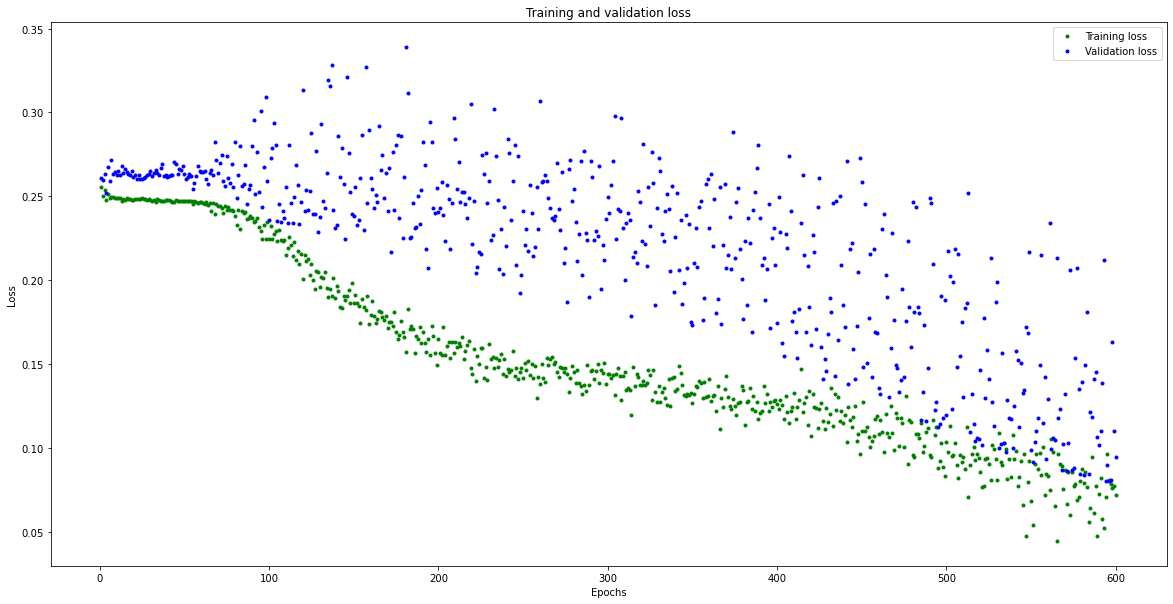

[20.0, 10.0]


In [58]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

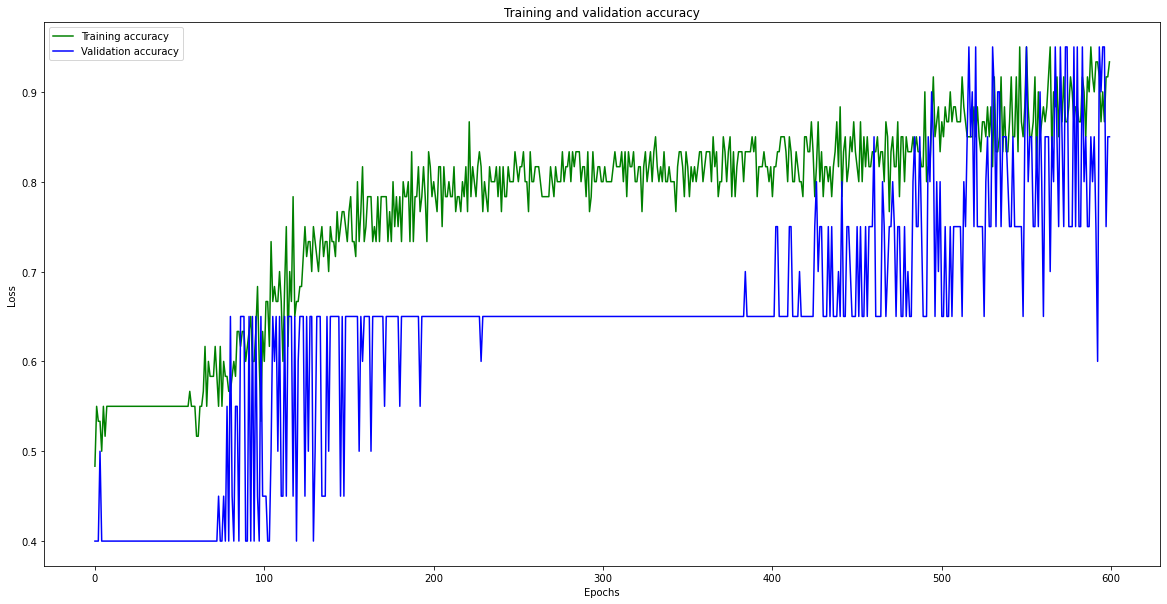

In [59]:
# graph the accuracy again skipping a bit of the start
SKIP = 0
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc[SKIP:], 'g', label='Training accuracy')
plt.plot(val_acc[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

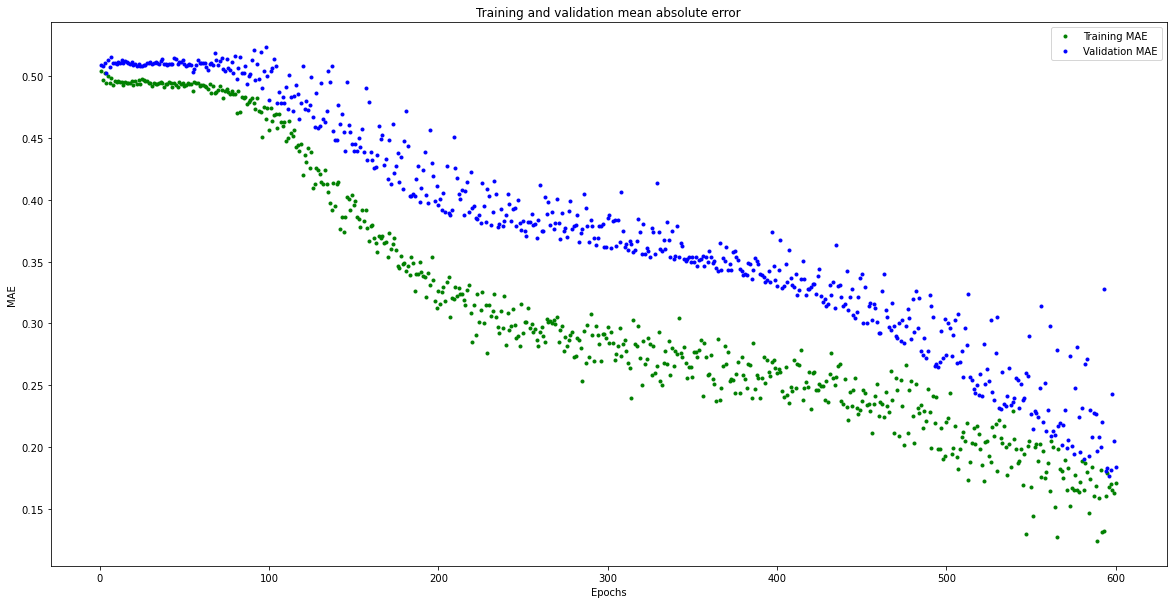

In [60]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Training accuracy:  0.9333333373069763
Validation accuracy:  0.8500000238418579


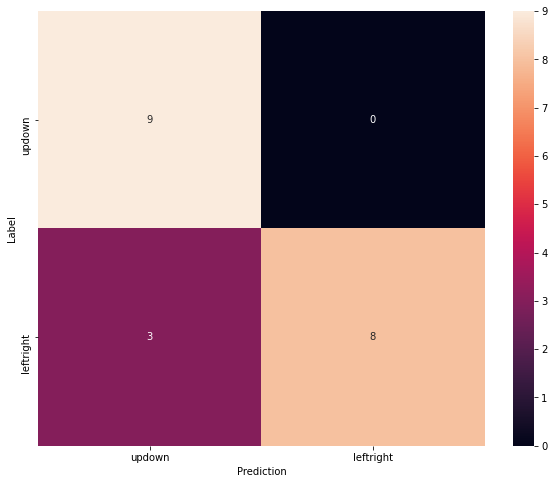

In [61]:
import seaborn as sns

# use the model to predict the test inputs
predictions = model.predict(inputs_test)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print('Training accuracy: ', acc[-1])
print('Validation accuracy: ', val_acc[-1])

def index_of_max(output_list):
  #takes a list of list
  #returns a list of the index of the max of the sub lists
  list_of_indicies = []
  for sub_list in output_list:
    list_of_indicies.append(np.argmax(sub_list))
  return list_of_indicies

confusion = tf.math.confusion_matrix(
    labels=tf.constant(index_of_max(outputs_test)),
    predictions=tf.constant(index_of_max(predictions)),
    num_classes=NUM_GESTURES)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, xticklabels=GESTURES, yticklabels=GESTURES, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
predictions[1]

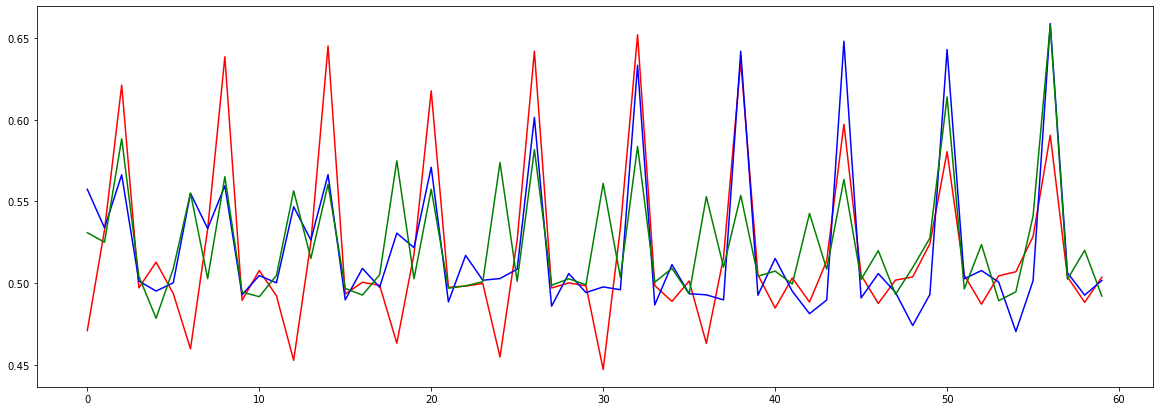

In [62]:
fig = plt.figure(figsize=(20, 7))
ax = plt.axes()


plt.plot(inputs_test[0], "r")
plt.plot(inputs_test[1], "b")
plt.plot(inputs_test[2], "g")
#plt.plot(df1["acc_y"], "g")
#plt.plot(df1["acc_z"], "b")
#plt.show()